# 完整的transformer模型

In [27]:
import torch
import torch.nn as nn

## 1. 位置编码（Positional Encoding）

$$PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

其中,
- `pos` 是序列中的位置索引
- `i` 是维度索引
- `d_model` 是模型的维度
- 偶数维度 `2i` 使用正弦函数
- 奇数维度 `2i+1` 使用余弦函数

In [33]:
# [TODO] 修改为使用register_buffer实现
class PositionalEncoding(nn.Module):
    """
    计算基于sin/cos的绝对位置编码
    """
    def __init__(self, d_model, max_len, device="cpu"):
        """
        初始化位置编码

        args:
            d_model: 输入矩阵的维度
            max_len: 最大序列长度
            device: device
        """
        super().__init__()

        # 与输入维度相同，用于与输入矩阵相加
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # 不需要梯度

        # 创建位置索引, shape = (max_len, 1)
        # 维度扩展方便后续广播机制的生效
        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)

        # 分别计算偶数维和奇数维的正弦和余弦值
        # 这里使用了广播机制，
        # pos的shape是(max_len, 1)，_2i的shape是(d_model/2)
        # 广播后的shape是(max_len, d_model/2)
        # 合并后的encoding的shape是(max_len, d_model)
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        batch_size, seq_len = x.size()

        # 根据输入的序列长度，返回对应的位置编码
        return self.encoding[:seq_len, :]


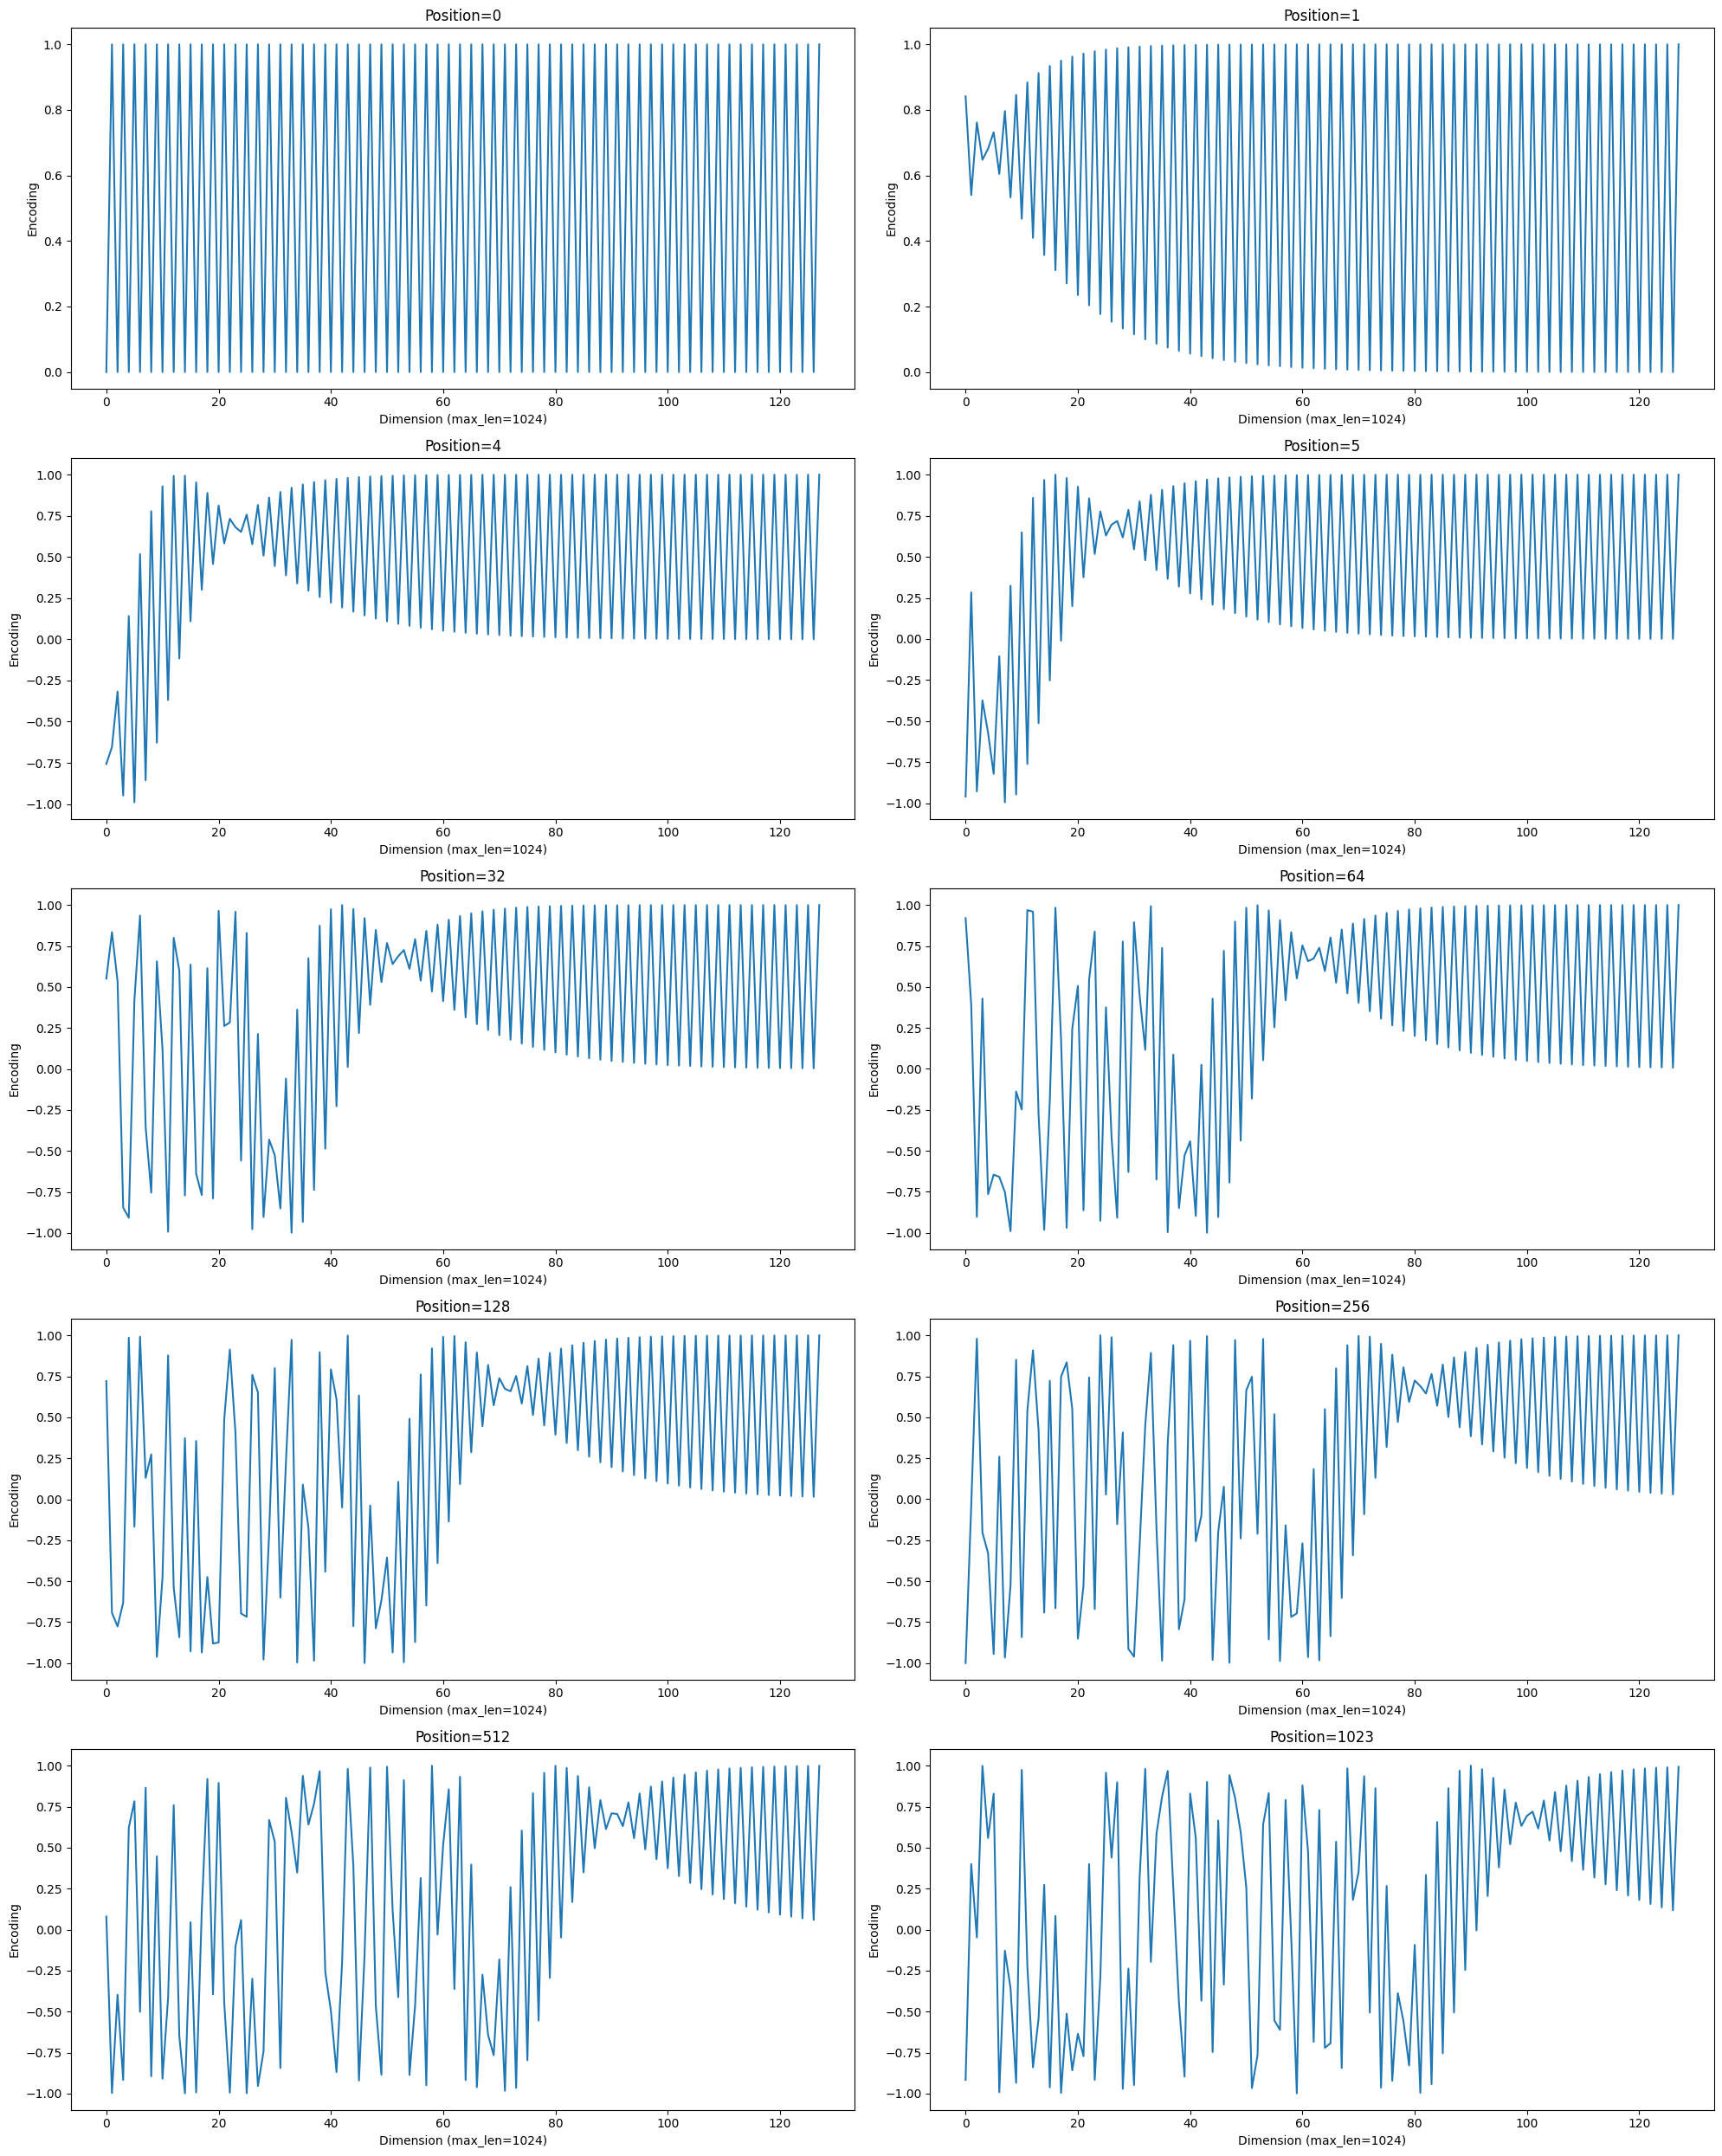

In [38]:
# 位置编码可视化
import matplotlib.pyplot as plt
# 设置matplotlib参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 分位置可视化，分别可视化0, 32, 64, 96, 128, 256, 512, 1024位置的编码
pos_enc = PositionalEncoding(d_model=128, max_len=1024,)
# 创建5x2的子图布局
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# 遍历位置并在对应子图中绘制
for idx, i in enumerate([0, 1, 4, 5, 32, 64, 128, 256, 512, 1023]):
    axes[idx].plot(pos_enc.encoding.numpy()[i, :])
    axes[idx].set_title(f"Position={i}")
    axes[idx].set_xlabel(f"Dimension (max_len={pos_enc.encoding.shape[0]})")
    axes[idx].set_ylabel("Encoding")

plt.tight_layout()
plt.show()

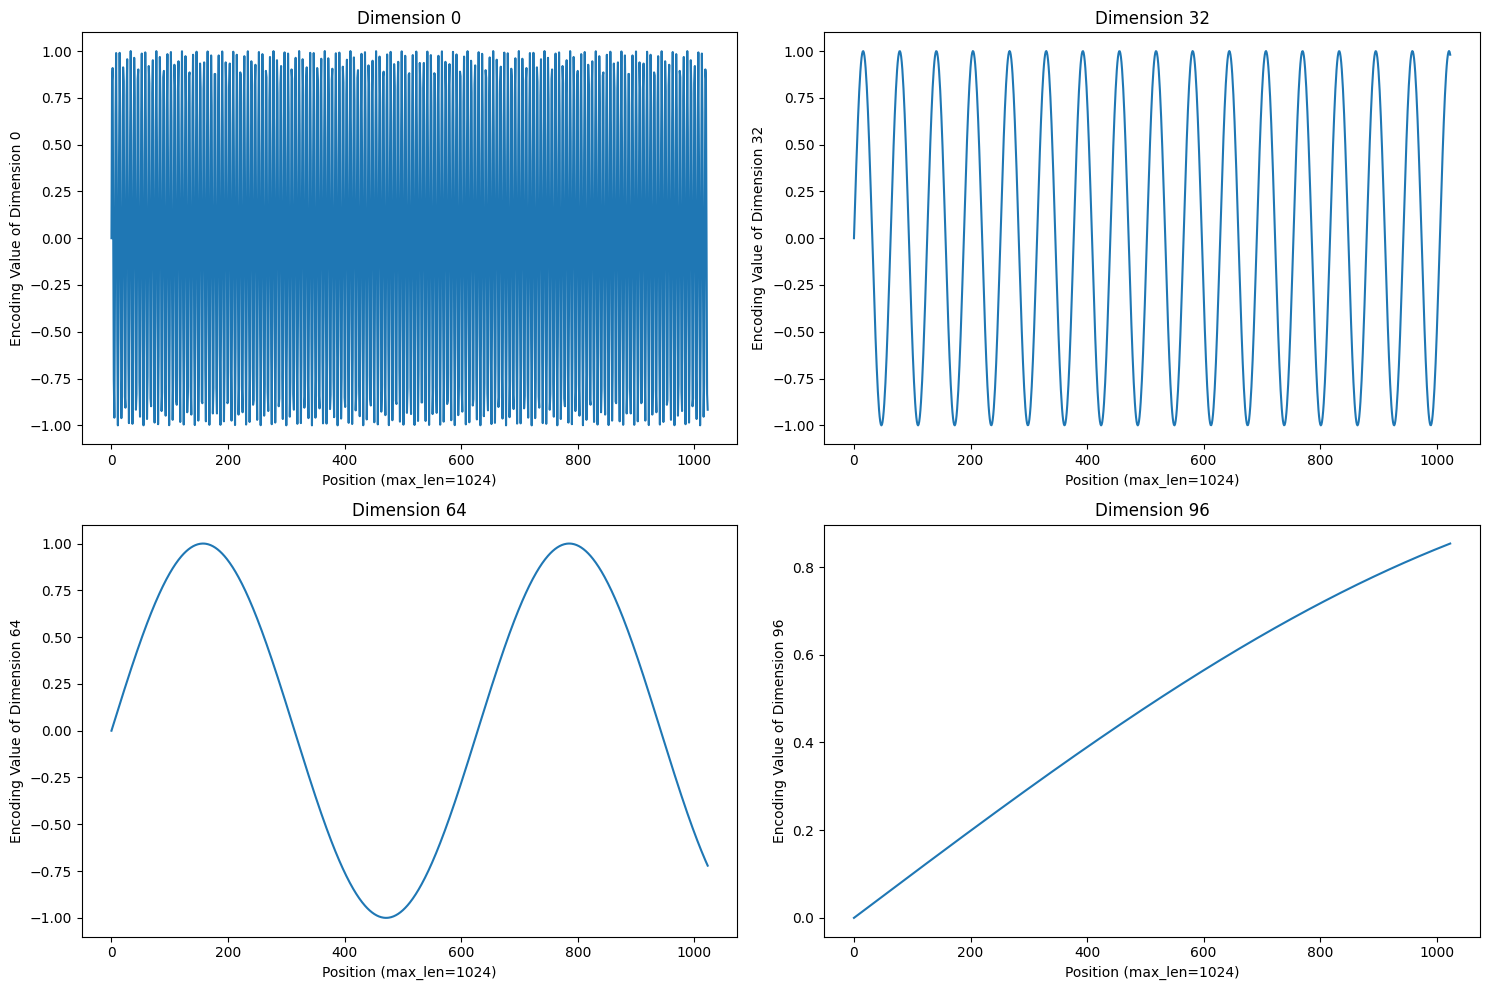

In [40]:
# 分维度可视化,分别可视化0,32,64,96维度的编码
pos_enc = PositionalEncoding(d_model=128, max_len=1024,)
# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# 遍历维度并在对应子图中绘制
for idx, i in enumerate([0, 32, 64, 96]):
    axes[idx].plot(pos_enc.encoding.numpy()[:, i])
    axes[idx].set_title(f"Dimension {i}")
    axes[idx].set_xlabel(f"Position (max_len={pos_enc.encoding.shape[0]})")
    axes[idx].set_ylabel(f"Encoding Value of Dimension {i}")

plt.tight_layout()
plt.show()

随着位置(pos)的变化
- 让我们以具体数值来理解(以128维为例)：
- 低维度（如维度0,2,4...）：
- 频率较高、周期短：1/10000^(0/128) = 1/1 = 1
- 变化较快，形成短周期波形
- 位置0→32→64→128时，编码值变化缓慢
- 高维度（如维度120,122,124...）：
- 频率很低、周期长：1/10000^(120/128) ≈ 1/6310
- 变化缓慢，形成长周期波形

位置编码的这种多尺度设计是Transformer能够有效处理序列数据
- 位置信息 = 细粒度信息 + 中粒度信息 + 粗粒度信息
- 低维度 → 细粒度：区分近距离位置关系（如相邻词级别） 
- 中维度 → 中粒度：区分中等距离位置关系（如短语级别）  
- 高维度 → 粗粒度：区分远距离位置关系（如句子级别）

相对位置编码：
- 任意两个位置的编码差异包含了它们的相对距离信息
- 模型可以学会通过编码差异来判断词与词之间的距离关系  
两个位置的差异： 
PE(j, 2i) - PE(i, 2i) = sin(j/w) - sin(i/w)  
                       = 2·cos((j+i)/(2w))·sin((j-i)/(2w))                        
其中 w = 10000^(2i/d_model)

## 2. 多头注意力机制（Multi-Head Attention）

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.n_head = n_head
        self.attention = ScaledDotProductAttention()
